In [96]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
def f(x):
  return 3*x**2 - 4*x + 5

In [98]:
f(3.0)

20.0

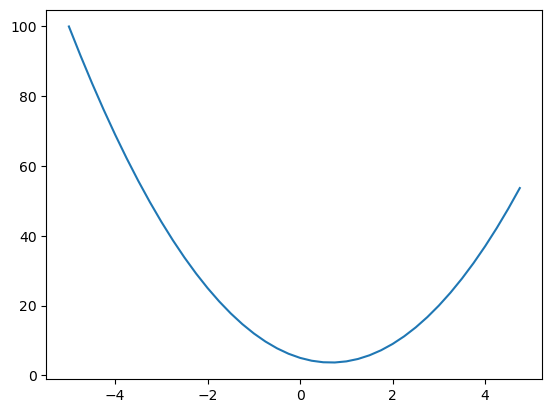

In [99]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [100]:
h = 0.000001
x = 2/3
# gradient function
(f(x + h) - f(x))/h

2.999378523327323e-06

In [101]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [102]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [103]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None #leaf node
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  

  # __add__ overloads the + operator
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    # fixing a backprop bug when one node is used multiple times
    def _backward():
        self.grad +=  1.0 * out.grad
        other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  
  def __pow__(self, other):
     assert isinstance(other, (int, float)), "only supporting int/float for now"
     out = Value(self.data**other, (self, ), f'**{other}')
    
     def _backward():
        self.grad += other * (self.data**(other - 1)) * out.grad
     out._backward = _backward
     return out 

  def __rmul__(self, other): #other * self
    return self * other
  
  def __radd__(self, other): #other + self
    return self + other
  
  def __truediv__(self, other): #self / other
     return self * (other ** -1)
  
  def __neg__(self):  # -self
    return self * -1
  
  def __sub__(self, other): #self - other
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
      
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  

  def tanh(self):
      x = self.data
      t = (math.exp(2*x) -1)/(math.exp(2*x) + 1) #local derivative 
      out = Value(t, (self, ), 'tanh')

      def _backward():
          self.grad += (1 - t**2) * out.grad
      out._backward = _backward

      return out
  
  def exp(self):
     x = self.data
     out = Value(math.exp(x), (self, ), 'exp')

     def _backward():
        self.grad += out.data * out.grad
     out._backward = _backward
  
     return out
  

  def backward(self):
  # build topological graph
      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev: 
            build_topo(child)
          topo.append(v)
      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()




In [104]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print(a)
print(b)
print(c)
e = a*b; 

e.label = 'e'
print(e)
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=2.0)
Value(data=-3.0)
Value(data=10.0)
Value(data=-6.0)


Value(data=-8.0)

In [105]:
def lol():

    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;  e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;  e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print((L2-L1)/h)


lol()


0.0


In [106]:
# change L by a tiny amt h, how much does L change (proportional, derivative 1)
# c.grad = -2.0
# d.grad = -2.0
# f.grad = 4.0
# e.grad = -2.0


# a.grad = (-2.0 * -3.0)
# b.grad = (2.0 * -2.0)

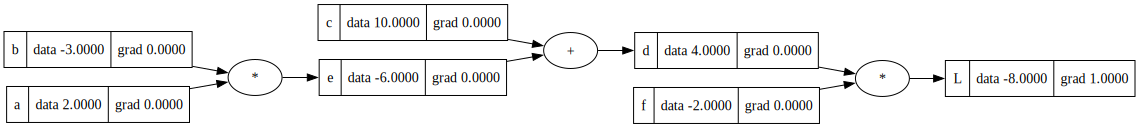

In [107]:
L.grad = 1.0
draw_dot(L)

In [108]:
# derive dL/dc
# dd/dc =1.0
# dd/de =1.0
# d = c+e

#want:
# dL/ dc = (dL/dd) * (dd/dc)

#e = a* b
# de/da ? b 
# dL/ de = -2.0
#dL / da = (dL/de) * (de / da)


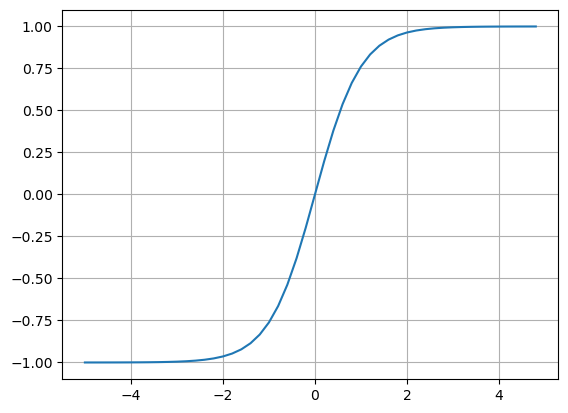

In [109]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [110]:
#

In [111]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


# o.grad = 1.0
# n.grad = 0.5 


# x1w1x2w2.grad = 0.5 
# b.grad = 0.5


# x1w1.grad = 0.5
# x2w2.grad = 0.5

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad


# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad
# o.grad = 1.0
# o._backward()



In [112]:
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()



In [113]:
# o = tanh(n)
# do/dn = 1 - o**2



In [114]:
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad


# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

In [115]:
# build topological graph

# o.grad = 1.0


# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#       visited.add(v)
#       for child in v._prev: 
#           build_topo(child)
#       topo.append(v)
# build_topo(o)
# topo

# for node in reversed(topo):
#     node._backward()

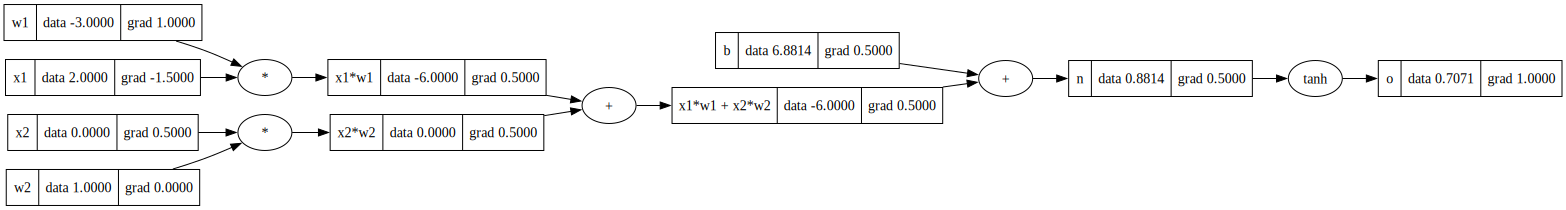

In [116]:
o.backward()
draw_dot(o)

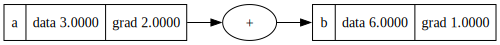

In [117]:
# bug when we are doing b = a + a change to accumulation

a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

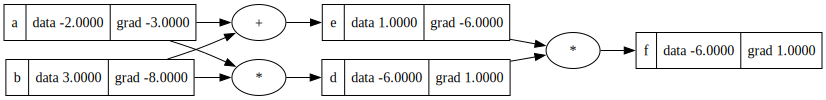

In [118]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

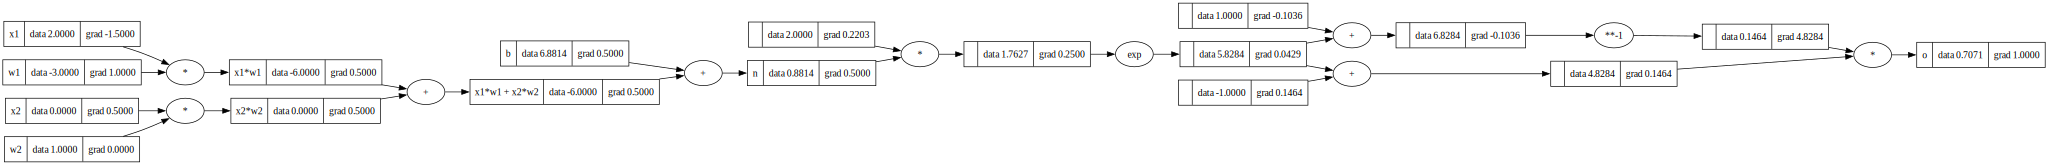

In [119]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# --- equivalent to doing tanh(x)
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'
# ---
o.backward()
draw_dot(o)


In [120]:
import torch
import random
class Neuron:
    
    def __init__(self, nin):
      self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
      self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
      # w * x + b
      act = sum((wi*xi for wi, xi in zip(self.w, x)),self.b)
      out = act.tanh()
      return out
    
    def parameters(self):
      return self.w + [self.b]

    
class Layer:
     def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
     def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
     
     def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons
        #   ps = neuron.parameters()
        #   params.extend(ps)
        #   return params
     
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.10170662557203908)

![Neuron Model](img/neuron_model.jpeg)

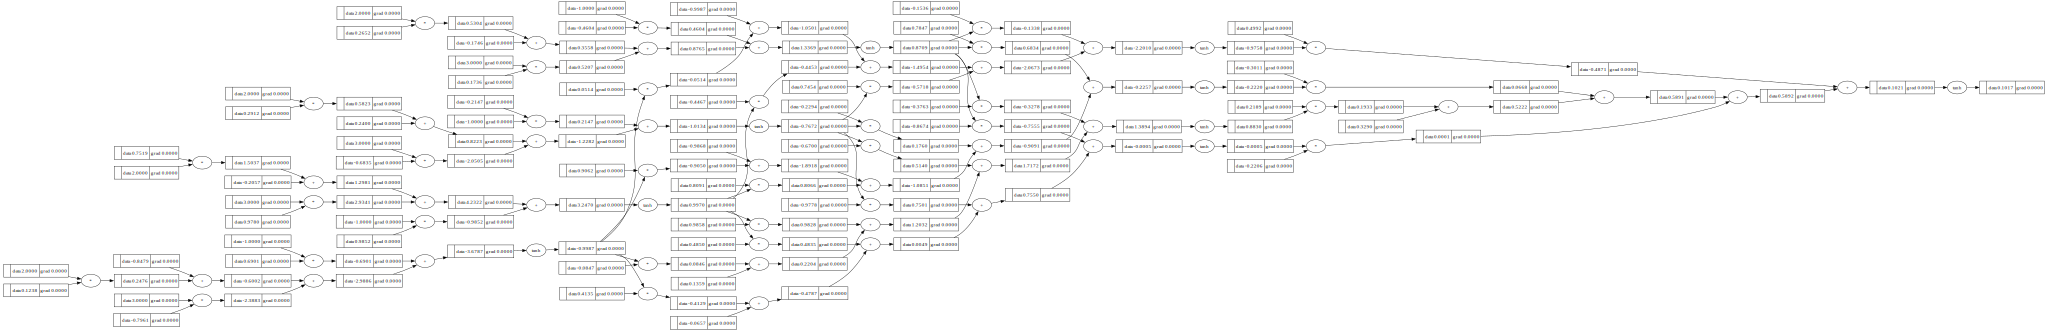

In [121]:
draw_dot(n(x))

![Neuron Model](img/neural_net2.jpeg)


In [131]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

## reset to zero, so that accums
    for p in n.parameters():
        p.grad = 0.0
    #backward pass
    loss.backward()

    for p in n.parameters():
        p.data -= 0.05 * p.grad

    print(k, loss.data)


ypred

0 0.005228942849389323
1 0.005186476514081254
2 0.005144676074817788
3 0.005103525902709742
4 0.00506301086273847
5 0.005023116293957228
6 0.0049838279906598
7 0.004945132184460572
8 0.004907015527234051
9 0.004869465074864957
10 0.004832468271763328
11 0.004796012936102172
12 0.00476008724573801
13 0.0047246797247763655
14 0.004689779230748049
15 0.00465537494236287
16 0.004621456347810434
17 0.004588013233578765
18 0.004555035673764036
19 0.004522514019845857


[Value(data=0.9560748646720735),
 Value(data=-0.968163360551502),
 Value(data=-0.9702887149617634),
 Value(data=0.973603704118339)]

In [123]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss.backward()

n.layers[0].neurons[0].w[0].grad
n.layers[0].neurons[0].w[0].data

0.43846458663996213

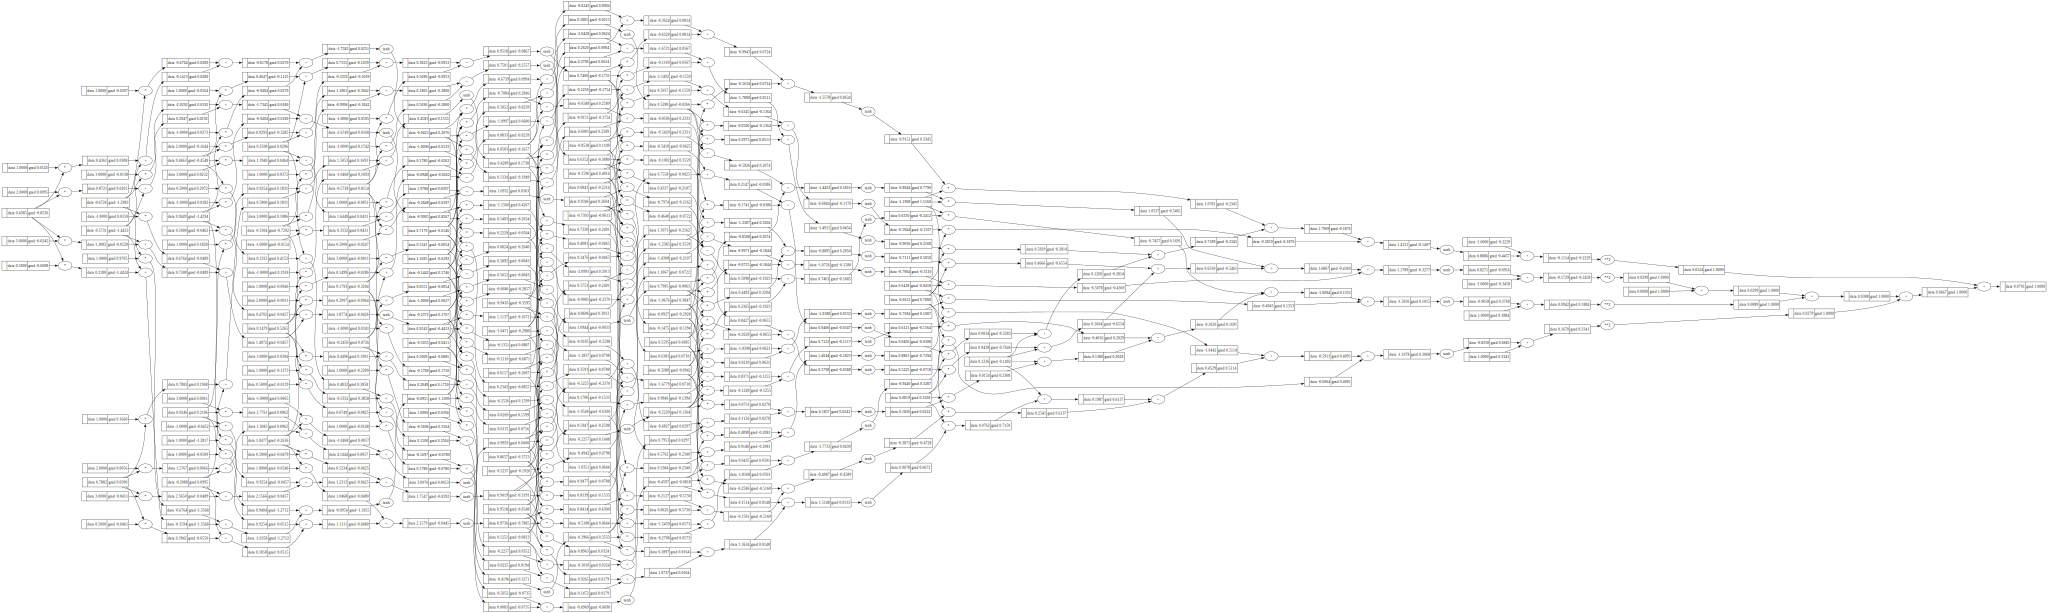

In [124]:
draw_dot(loss)

In [125]:
for p in n.parameters():
    p.data += -0.1 * p.grad

In [126]:
ypred

[Value(data=0.8271117312019611),
 Value(data=-0.9057997969045588),
 Value(data=-0.8329703424471067),
 Value(data=0.8885678645649145)]